In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation,Input, GlobalAveragePooling2D,Resizing
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

In [4]:
picture_size = 128
folder_path = "/kaggle/input/20k-multi-class-crop-disease-images"

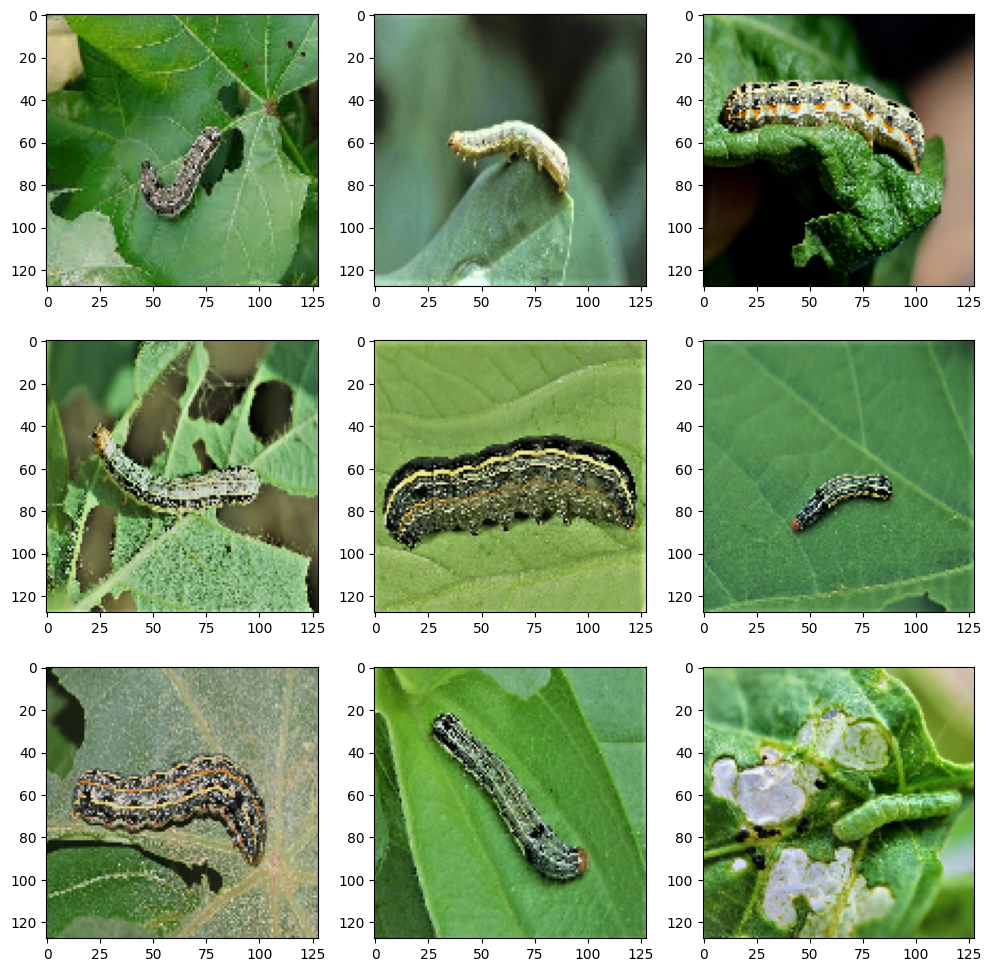

In [5]:
expression = 'Army worm'

plt.figure(figsize= (12,12))
for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    img = load_img(folder_path+"/Train/"+expression+"/"+
                  os.listdir(folder_path + "/Train/" + expression)[i], target_size=(picture_size, picture_size))
    plt.imshow(img)   
plt.show()

In [4]:
# ✅ Image Size & Batch Size
IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 25
NUM_FOLDS = 5  # Cross-validation folds
num_classes = 42 

In [5]:
# ✅ Data Augmentation to avoid overfitting
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# ✅ Load Dataset Paths & Labels
data_dir = folder_path+"/Train/"
categories = os.listdir(data_dir)
num_classes = len(categories)
num_classes

42

In [6]:
X = []  # Image Paths
y = []  # Labels

for idx, category in enumerate(categories):
    category_path = os.path.join(data_dir, category)
    for img_name in os.listdir(category_path):
        X.append(os.path.join(category_path, img_name))
        y.append(idx)

In [7]:
X = np.array(X)
y = np.array(y)

In [8]:
# ✅ Define Cross-Validation (Stratified K-Fold)
skf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

fold_no = 1

# Convert integer labels to string labels
category_labels = {idx: category for idx, category in enumerate(categories)}
y_str = np.array([category_labels[idx] for idx in y])  # Convert y to string labels

for train_index, val_index in skf.split(X, y_str):  # Use y_str for stratification
    print(f"\nTraining Fold {fold_no}/{NUM_FOLDS}")

    # ✅ Create DataFrame with string labels
    train_df = pd.DataFrame({"filename": X[train_index], "class": y_str[train_index]})
    val_df = pd.DataFrame({"filename": X[val_index], "class": y_str[val_index]})

    train_data = datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col="filename",
        y_col="class",
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical'  # Ensures labels are correctly interpreted
    )

    val_data = datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col="filename",
        y_col="class",
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )



Training Fold 1/5
Found 12269 validated image filenames belonging to 42 classes.
Found 3067 validated image filenames belonging to 41 classes.

Training Fold 1/5
Found 12268 validated image filenames belonging to 42 classes.
Found 3068 validated image filenames belonging to 41 classes.

Training Fold 1/5
Found 12268 validated image filenames belonging to 42 classes.
Found 3068 validated image filenames belonging to 41 classes.

Training Fold 1/5
Found 12269 validated image filenames belonging to 42 classes.
Found 3067 validated image filenames belonging to 42 classes.

Training Fold 1/5
Found 12270 validated image filenames belonging to 42 classes.
Found 3066 validated image filenames belonging to 42 classes.


In [9]:
# ✅ Define Input Layer
input_layer = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# ✅ Custom CNN Block
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D(pool_size=(2, 2))(x)

# ✅ Ensure Correct Shape Before MobileNetV2
x = Conv2D(3, (1, 1), activation='relu', padding='same')(x)  # Convert channels to 3
x = Resizing(IMG_SIZE, IMG_SIZE)(x)  # ✅ Correct way to resize in Keras

# ✅ Load MobileNetV2
base_model = MobileNetV2(weights='/kaggle/input/mobilenetv22/tensorflow2/default/1/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # Freeze MobileNetV2 layers

x = base_model(x)
x = GlobalAveragePooling2D()(x)  # Reduce dimensions
x = Dense(128, activation='relu')(x)  # Fully connected layer
output_layer = Dense(num_classes, activation='softmax')(x)  # Output layer

In [10]:
# ✅ Define Model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 3)           │             195 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resizing (Resizing)                  │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_128 (Functional)    │ (None, 4, 4, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 42)                  │           5,418 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,429,357 (9.27 MB)

 Trainable params: 171,373 (669.43 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [11]:
# ✅ Define Callbacks
checkpoint = ModelCheckpoint(f"crop_disease_fold{fold_no}.keras", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [ ]:
# ✅ Train Model
model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=[checkpoint, reduce_lr, early_stopping]
    )

fold_no += 1  # Move to next fold

Epoch 1/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 873ms/step - accuracy: 0.4259 - loss: 2.2055
Epoch 1: val_accuracy improved from -inf to 0.63144, saving model to crop_disease_fold1.keras
384/384 ━━━━━━━━━━━━━━━━━━━━ 401s 1s/step - accuracy: 0.4261 - loss: 2.2043 - val_accuracy: 0.6314 - val_loss: 1.2774 - learning_rate: 0.0010
Epoch 2/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 863ms/step - accuracy: 0.6575 - loss: 1.1760
Epoch 2: val_accuracy improved from 0.63144 to 0.66830, saving model to crop_disease_fold1.keras
384/384 ━━━━━━━━━━━━━━━━━━━━ 380s 982ms/step - accuracy: 0.6575 - loss: 1.1759 - val_accuracy: 0.6683 - val_loss: 1.0880 - learning_rate: 0.0010
Epoch 3/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 864ms/step - accuracy: 0.7055 - loss: 1.0112
Epoch 3: val_accuracy improved from 0.66830 to 0.69602, saving model to crop_disease_fold1.keras
384/384 ━━━━━━━━━━━━━━━━━━━━ 380s 984ms/step - accuracy: 0.7055 - loss: 1.0111 - val_accuracy: 0.6960 - val_loss: 1.0440 - learning_rate: 0.0010
Epoch 4/25
384/3

In [4]:
print(3*'abc'+'def')

abcabcabcdef
